In [74]:
import pandas
import tensorflow as tf
import numpy as np

El código está hecho bastante genérico, de forma que si se cambia el tamaño de las matrices del fichero, o el formato en el que están escritas, solo será necesario cambiar algunos números en esta primera función (o hacer otra y aplicarla en la siguiente celda)

In [75]:
def txt_to_array(name):
    #Función q pasa los datos del fichero indicado a un vector de matrices complejas.
    #Esta hecha para el formato en el q Dani me ha pasado los datos entangled.txt y separable.txt
    #Estos 2 ficheros tienen q estar en la misma carpeta q este código.
    
    ncol = max(len(l.split()) for l in open(name))
    df = pandas.read_table(name, 
                       delim_whitespace=True, 
                       header=None, 
                       usecols=range(ncol), 
                       engine='python')
    
    #Creamos el np.array
    a=np.array(df.fillna(0))#con esto rellenamos de 0 los huecos vacíos. (la 5ª fila de cada matriz solo tiene un 1 o 0)
    #Ahora mismo tengo un vector con 50000 filas y 8 columnas
    
    #Creo un vector con 10.000 matrices de 5x8
    b=np.zeros(shape=(10000,5,8))
    k=-1
    for i in range (0,a.shape[0]):
        if(i%5==0):
            k=k+1
            p=-1
        p=p+1
        for j in range (0,a.shape[1]):
            #print(k,p,j,i,j)
            b[k,p,j]=a[i,j]
            
    #Elimino la 5ª fila de cada matriz, q es donde está especificado si es entangled o separable
    c=np.zeros(shape=(10000,4,8))
    for i in range (0,b.shape[0]):
        c[i]=np.delete(b[i],4,axis=0)
        
    #Transformo las matrices 4x8 en 4x4 complejas
    vector_matrices=np.zeros(shape=(10000,4,4))+np.zeros(shape=(10000,4,4))*1j
    for i in range(0,c.shape[0]):
        for j in range(0,c.shape[1]):
            for k in range(0,c.shape[2],2):
                p=np.int(k/2)
                vector_matrices[i,j,p]=c[i,j,k]+c[i,j,k+1]*1j
    
    return vector_matrices
    

In [76]:
def txt_to_array_2(name):
    #Función q pasa los datos del fichero indicado a un vector de matrices complejas.
    #Esta hecha para el formato en el q Dani ha pasado el 2º set de datos (4 ficheros).
    #Cada fila es una matriz y tiene 32 columnas: real-complejo, real - complejo ...
    #Estos ficheros tienen q estar en la misma carpeta q este código.
    ncol = max(len(l.split()) for l in open(name))
    df = pandas.read_table(name, 
                       delim_whitespace=True, 
                       header=None, 
                       usecols=range(ncol), 
                       engine='python')
    #print(df.shape)
    #Hacemos el vector df un vector numpy
    df=np.array(df)
    #Pasamos a shape=10.000,4,8
    a=np.zeros(shape=(10000,4,8))
    
    for i in range (0,df.shape[0]):
        k=-1
        for j in range (0,df.shape[1]):
            if(j%8==0):
                k=k+1
                p=-1
            p=p+1
            #print(k,p,j,i,j)
            a[i,k,p]=df[i,j]
            
    #Transformo las matrices 4x8 en 4x4 complejas
    vector_matrices=np.zeros(shape=(10000,4,4))+np.zeros(shape=(10000,4,4))*1j
    for i in range(0,a.shape[0]):
        for j in range(0,a.shape[1]):
            for k in range(0,a.shape[2],2):
                p=np.int(k/2)
                vector_matrices[i,j,p]=a[i,j,k]+a[i,j,k+1]*1j

        
        
    return vector_matrices
    

In [77]:
entangled=txt_to_array("entangled_old.txt")
separable=txt_to_array("separable_old.txt")
#print(separable.shape)
#print(" ")
#separable[0]

Ahora mismo tenemos 2 vectores de matrices complejas 4x4, cada vector con 10.000 matrices.
Se procede crear una función para aplicar el criterio ppt.

In [78]:
def PT_B(M, d1, d2):
    """
    Partial Transpose map of M
    Input: Matrix M, Dimension d1 of subsystem 1, Dimension d2 of subsystem 2
    Output: Partial Transpose M_TB
    """
    assert M.shape == (d1 * d2, d1 * d2)

    # Reshape into 4 tensor
    M = M.reshape(d1, d2, d1, d2)

    # Transpose 2nd system
    M = M.transpose((0, 3, 2, 1))

    # Reshape back into a density matrix
    return M.reshape(d1 * d2, d1 * d2)

In [79]:
#Esto es una mera comprobación de q los autovalores son reales.
x=PT_B(separable[1],2,2)
#print(x)
z=np.linalg.eig(x)#z[0] son los autoval. y z[1] los autovect.
#len(z[0])
print(z[0])

[ 1.00000052e+00-2.80284071e-17j  6.84248738e-07-4.67229456e-18j
 -2.65917374e-07+1.48545264e-17j -9.35622523e-07-7.01580342e-18j]


In [80]:
def ppt_criterion(p):
    #función q recibe una matriz densidad (autoadjunta y traza=1) y devuelve si pertenece a un estado
    #entangled (1) o a uno separable (0), aplicando el Peres-Horodecki Criterion"
    
    salida=0
    p_trasp_parcial=PT_B(p,2,2)#traspuesta parcial de una matriz densidad p de 2 subsistemas con dim 2
    z=np.linalg.eig(p_trasp_parcial)#Se crea una tupla con los autovalores z[0] y autovectores z[1]
    #Los autoval. son reales aunque normalmente la parte imaginaria no se hace cero, sino ~1.0e-16
    for i in range(0,len(z[0])):
        if(z[0][i]<-1.0e-4):#le meto algo de tolerancia, ya q con muchas matrices separables (0) se obtienen autoval -1e-7 aprox
            salida=1    #autoval negativo = entrelazado
            

    return salida

In [81]:
x=ppt_criterion(entangled[5])
print(x)

1


Creamos el vector examples con las 10.000 + 10.000, mezclando aleatoriamente.
Recuerda q hay q inicializarlo como complejo.

In [82]:
examples=np.zeros(shape=(entangled.shape[0]+separable.shape[0],entangled.shape[1],entangled.shape[2]))+np.zeros(shape=(entangled.shape[0]+separable.shape[0],entangled.shape[1],entangled.shape[2]))*1j
#examples=np.append(entangled,separable)
#examples=entangled
#examples.shape
for i in range (0,entangled.shape[0]):
    examples[i]=entangled[i]

for i in range (entangled.shape[0],entangled.shape[0]+separable.shape[0]):#Desde 10.000 a 20.000 vaya
    examples[i]=separable[i-entangled.shape[0]]
examples.shape
#ppt_criterion(examples[0])
#print(examples[19999])

(20000, 4, 4)

In [83]:
np.random.shuffle(examples)#mezclamos aleatoriamente los elementos del vector.
np.random.shuffle(examples)
#ppt_criterion(examples[25])

#80% para entrenamiento
aux=np.int(0.8*examples.shape[0])
train=np.zeros(shape=(aux,examples.shape[1],examples.shape[2]))+np.zeros(shape=(aux,examples.shape[1],examples.shape[2]))*1j

#20% para probarlos
aux=np.int(0.2*examples.shape[0])
test=np.zeros(shape=(aux,examples.shape[1],examples.shape[2]))+np.zeros(shape=(aux,examples.shape[1],examples.shape[2]))*1j

for i in range (0,train.shape[0]):
    train[i]=examples[i]
    
for i in range(train.shape[0],train.shape[0]+test.shape[0]):#de 16.000 a 20.000 vaya
    test[i-train.shape[0]]=examples[i]
    
print(train.shape)
print(test.shape)
print(ppt_criterion(train[15999]))
print(ppt_criterion(test[0]))

(16000, 4, 4)
(4000, 4, 4)
1
0


-----------------------------------------------------------------------------
Aplico la función ppt_criterion para tener las salidas de la red.

¡¡¡¡¡IMPORTANTE: SI SE EJECUTA LA CELDA ANTERIOR HAY Q EJECUTAR LA QUE SIGUE. SINO EL VECTOR y CON EL QUE LA RED APRENDE NO ESTÁ SINCRONIZADO CON EL DE ENTRENAMIENTO.

In [84]:
y_train=np.zeros(shape=(train.shape[0],1))
y_test=np.zeros(shape=(test.shape[0],1))

for i in range(0,train.shape[0]):
    y_train[i]=ppt_criterion(train[i])
    
for i in range(0,test.shape[0]):
    y_test[i]=ppt_criterion(test[i])
    
print(y_train.shape)
print(y_test.shape)
print(np.sum(y_train))
print(np.sum(y_test))

(16000, 1)
(4000, 1)
8041.0
1959.0


    --------------------------------------------------------------------------------------------------------------------
Los vectores y son los que evaluarán la red.
Ahora antes de meter el train y el test en la red hay que prepararlos para ello.
Recuerda que la red no acepta números complejos.
Ojo q aunque los de la diagonal realmente tengan parte imaginaria 0, para el ordenador tienen una parte imag. muy muy pequeña.
Para codificarlos, dado que la matriz es hermítica, necesito 16 números reales: 4 hacen referencia a los reales de la diagonal, 6 a los reales que están x encima de la diagonal, y otros 6 a los complejos. Supongo que el orden en el que se los meta no importa.

In [85]:
##Esto por si quiero testear con otros datos. Compilar este cuadro, el siguiente, y los 2 últimos. En el penúltimo hay q poner
##la y_test que corresponda con np.ones o zeros.
#test=txt_to_array_2('mixed_entangled.txt')

In [86]:
x_train=np.zeros(shape=(train.shape[0],train.shape[1]*train.shape[2]))  #16000 ejemplos con 16 reales cada uno para el entrenamiento.
x_test=np.zeros(shape=(test.shape[0],test.shape[1]*test.shape[2]))
for p in range(0,x_train.shape[0]):
    k=0
    for i in range(0,train.shape[1]):
        for j in range(i, train.shape[2]):     #Partiendo con j desde i solo cojo los valores a la derecha de la diagonal
            if(i==j):                            #si el nº está en la diagonal nos quedamos con la parte real solo
                x_train[p,k]=train[p,i,j].real
                k=k+1
            else:
                x_train[p,k]=train[p,i,j].real
                k=k+1
                x_train[p,k]=train[p,i,j].imag
                k=k+1
            #print(i,"    ",j,"     ",k)
            
            
for p in range(0,x_test.shape[0]):
    k=0
    for i in range(0,test.shape[1]):
        for j in range(i, test.shape[2]):
            if(i==j):                            #si el nº está en la diagonal nos quedamos con la parte real solo
                x_test[p,k]=test[p,i,j].real
                k=k+1
            else:
                x_test[p,k]=test[p,i,j].real
                k=k+1
                x_test[p,k]=test[p,i,j].imag
                k=k+1
                    
print(x_train.shape)
print(x_test.shape)
#print(x_train[0])
#print("     ")
#print(train[0])

(16000, 16)
(4000, 16)


---------------------------
Finalmente se introduce todo en la red.

In [87]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers.core import Dense

In [88]:
 
model = Sequential()
model.add(Dense(32, input_dim=x_train.shape[1], activation='relu'))
#model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
 
model.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=['binary_accuracy'])
 
history=model.fit(x_train, y_train, epochs=15)#, validation_data=(x_test,y_test))
 


Epoch 1/15
16000/16000 [==============================] - 1s 48us/step - loss: 0.2372 - binary_accuracy: 0.9249
Epoch 2/15
16000/16000 [==============================] - 1s 37us/step - loss: 0.0018 - binary_accuracy: 1.0000
Epoch 3/15
16000/16000 [==============================] - 1s 35us/step - loss: 4.5673e-04 - binary_accuracy: 1.0000
Epoch 4/15
16000/16000 [==============================] - 1s 34us/step - loss: 1.9551e-04 - binary_accuracy: 1.0000
Epoch 5/15
16000/16000 [==============================] - 1s 35us/step - loss: 1.0387e-04 - binary_accuracy: 1.0000
Epoch 6/15
16000/16000 [==============================] - 1s 34us/step - loss: 6.1623e-05 - binary_accuracy: 1.0000
Epoch 7/15
16000/16000 [==============================] - 1s 35us/step - loss: 3.9120e-05 - binary_accuracy: 1.0000
Epoch 8/15
16000/16000 [==============================] - 1s 33us/step - loss: 2.5962e-05 - binary_accuracy: 1.0000
Epoch 9/15
16000/16000 [==============================] - 1s 35us/step - loss: 1

In [89]:
val_loss, val_acc = model.evaluate(x_test, y_test)
print(val_loss)
print(val_acc)

4000/4000 [==============================] - 0s 23us/step
2.1328196703507273e-06
1.0


In [90]:
import matplotlib.pyplot as plt

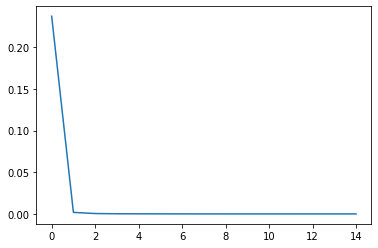

In [91]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])

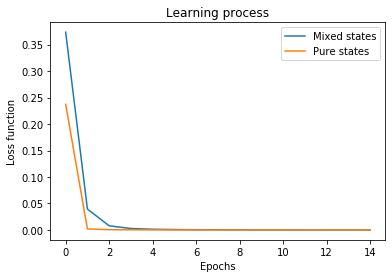

In [92]:
plt.plot(history_mixed.history['loss'], label='Mixed states')
plt.plot(history.history['loss'], label='Pure states')
plt.title('Learning process')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

------------------------------
Y para verlo con mis propios ojos:

In [93]:
q=model.predict(x_test).round()#salida de la red correspondiente a lo que introduzca en el paréntesis
print(q)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [94]:
r=3999
print(x_test[r])
print(" ")
print(test[r])#matriz densidad correspondiente al x_test que se le mete a la red
print(" ")
print(ppt_criterion(test[r]))#Este nº y el de abajo ( q es el q sale de la red) tienen q ser los mismos.
print(q[r])

[ 0.026064  0.013127  0.056403  0.052292  0.03125  -0.041289  0.1289
  0.128669  0.093962 -0.097423  0.258148  0.15427   0.142382  0.07171
  0.308116  0.702885]
 
[[ 0.026064+0.j        0.013127+0.056403j  0.052292+0.03125j
  -0.041289+0.1289j  ]
 [ 0.013127-0.056403j  0.128669+0.j        0.093962-0.097423j
   0.258148+0.15427j ]
 [ 0.052292-0.03125j   0.093962+0.097423j  0.142382+0.j
   0.07171 +0.308116j]
 [-0.041289-0.1289j    0.258148-0.15427j   0.07171 -0.308116j
   0.702885+0.j      ]]
 
0
[0.]


In [95]:
#y_test=np.ones(shape=x_test.shape[0])
#y_test.shape

In [96]:
#val_loss, val_acc = model.evaluate(x_test, y_test)
#print(val_loss)
#print(val_acc)